In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from astropy.table import Table
import multiprocessing as mp 

import pandas
pandas.set_option('display.max_columns', None)

%matplotlib inline
%config InlineBackend.figure_format='retina'
plt.style.use(['labstyle.mplstyle']) 

# Importing data

In [2]:
results = Table.read('SDSS_LAB2024_PROFresults.fits', format='fits')
results = results.to_pandas()
results

,id,bayes.attenuation.E_BVs.stellar.young,bayes.attenuation.E_BVs.stellar.young_err,bayes.sfh.age,bayes.sfh.age_err,bayes.sfh.tau_main,bayes.sfh.tau_main_err,bayes.sfh.sfr,bayes.sfh.sfr_err,bayes.stellar.m_star,bayes.stellar.m_star_err,bayes.sdss.gp,bayes.sdss.gp_err,bayes.sdss.ip,bayes.sdss.ip_err,bayes.sdss.rp,bayes.sdss.rp_err,bayes.sdss.up,bayes.sdss.up_err,bayes.sdss.zp,bayes.sdss.zp_err,best.chi_square,best.reduced_chi_square,best.attenuation.B_B90,best.attenuation.E_BVs.nebular.continuum_old,best.attenuation.E_BVs.nebular.continuum_young,best.attenuation.E_BVs.nebular.lines_old,best.attenuation.E_BVs.nebular.lines_young,best.attenuation.E_BVs.stellar.old,best.attenuation.E_BVs.stellar.young,best.attenuation.V_B90,best.attenuation.ebvs_old_factor,best.attenuation.powerlaw_slope,best.attenuation.uv_bump_amplitude,best.attenuation.uv_bump_wavelength,best.attenuation.uv_bump_width,best.nebular.f_dust,best.nebular.f_esc,best.nebular.lines_width,best.nebular.logU,best.nebular.ne,best.nebular.zgas,best.sfh.age,best.sfh.burst_age,best.sfh.f_burst,best.sfh.tau_burst,best.sfh.tau_main,best.stellar.age_m_star,best.stellar.imf,best.stellar.metallicity,best.stellar.old_young_separation_age,best.universe.age,best.universe.luminosity_distance,best.universe.redshift,best.attenuation.nebular.continuum_old,best.attenuation.nebular.continuum_young,best.attenuation.nebular.lines_old,best.attenuation.nebular.lines_young,best.attenuation.stellar.old,best.attenuation.stellar.young,best.dust.luminosity,best.sfh.integrated,best.sfh.sfr,best.sfh.sfr100Myrs,best.sfh.sfr10Myrs,best.stellar.lum,best.stellar.lum_ly,best.stellar.lum_ly_old,best.stellar.lum_ly_young,best.stellar.lum_old,best.stellar.lum_young,best.stellar.m_gas,best.stellar.m_gas_old,best.stellar.m_gas_young,best.stellar.m_star,best.stellar.m_star_old,best.stellar.m_star_young,best.stellar.n_ly,best.stellar.n_ly_old,best.stellar.n_ly_young,best.sdss.up,best.sdss.gp,best.sdss.rp,best.sdss.ip,best.sdss.zp
0,1237657873254907919,0.246312,0.195925,1999.112517,960.516317,373.966355,291.577328,0.205591,0.291975,3.947004e+09,8.204043e+08,0.834379,0.032023,1.984993,0.023976,1.515246,0.024553,0.206598,0.013534,2.510062,0.068503,32.328839,8.082210,1.164679,0.220,0.50,0.220,0.50,0.220,0.50,0.925299,0.44,0.0,0.0,217.5,35.0,0.0,0.0,300.0,-2.0,100.0,0.02,1100.0,1.0,0.0,1.0,300.0,820.907242,1.0,0.02,10.0,13368.111980,3.803276e+24,0.028312,6.963647e+32,5.257564e+34,1.558116e+33,1.111303e+35,2.340102e+36,9.190453e+35,3.425108e+36,5.412972e+09,0.474101,0.561744,0.481288,6.322693e+36,2.342789e+35,4.989946e+33,2.292889e+35,5.136567e+36,1.186126e+36,2.039222e+09,2.038934e+09,2.873732e+05,3.373750e+09,3.369225e+09,4.525509e+06,7.058673e+52,1.149902e+51,6.943682e+52,0.213476,0.875874,1.496543,1.975366,2.490150
1,1237657873254973544,0.242590,0.147526,4242.216616,2997.810626,8458.942235,3979.155808,1.233340,0.809994,2.975272e+09,1.105974e+09,0.242731,0.006881,0.448915,0.007785,0.348413,0.003826,0.095799,0.005866,0.524433,0.017343,0.295336,0.073834,0.251790,0.044,0.10,0.044,0.10,0.044,0.10,0.194575,0.44,0.0,0.0,217.5,35.0,0.0,0.0,300.0,-2.0,100.0,0.02,1800.0,1.0,0.0,1.0,700.0,1226.855537,1.0,0.02,10.0,13003.015620,7.708407e+24,0.056195,1.853166e+32,2.494295e+34,4.675935e+32,5.990855e+34,4.194243e+35,5.103567e+35,1.015285e+36,3.682253e+09,0.435609,0.467926,0.438422,4.073873e+36,2.137705e+35,3.708738e+33,2.100617e+35,2.990447e+36,1.083426e+36,1.466159e+09,1.465899e+09,2.607138e+05,2.216093e+09,2.211970e+09,4.123507e+06,6.450897e+52,8.871794e+50,6.362179e+52,0.092026,0.250001,0.361656,0.444360,0.507239
2,1237654880726286453,0.346988,0.297202,6976.770465,3166.220618,3606.148039,3770.936761,1.715091,2.535770,2.219241e+10,5.856282e+09,0.207946,0.005878,0.652436,0.009215,0.448584,0.017435,0.049471,0.004802,0.884839,0.029827,0.344524,0.086131,0.778373,0.154,0.35,0.154,0.35,0.154,0.35,0.626742,0.44,0.0,0.0,217.5,35.0,0.0,0.0,300.0,-2.0,100.0,0.02,1950.0,1.0,0.0,1.0,300.0,1647.130306,1.0,0.02,10.0,12764.994344,1.042477e+

In [3]:
x_data = results['best.stellar.m_star']
y_data = results['best.sfh.sfr10Myrs']/results['best.stellar.m_star']

x_data = np.log10(x_data)
y_data = np.log10(y_data)

# Bimodal gaussian fit

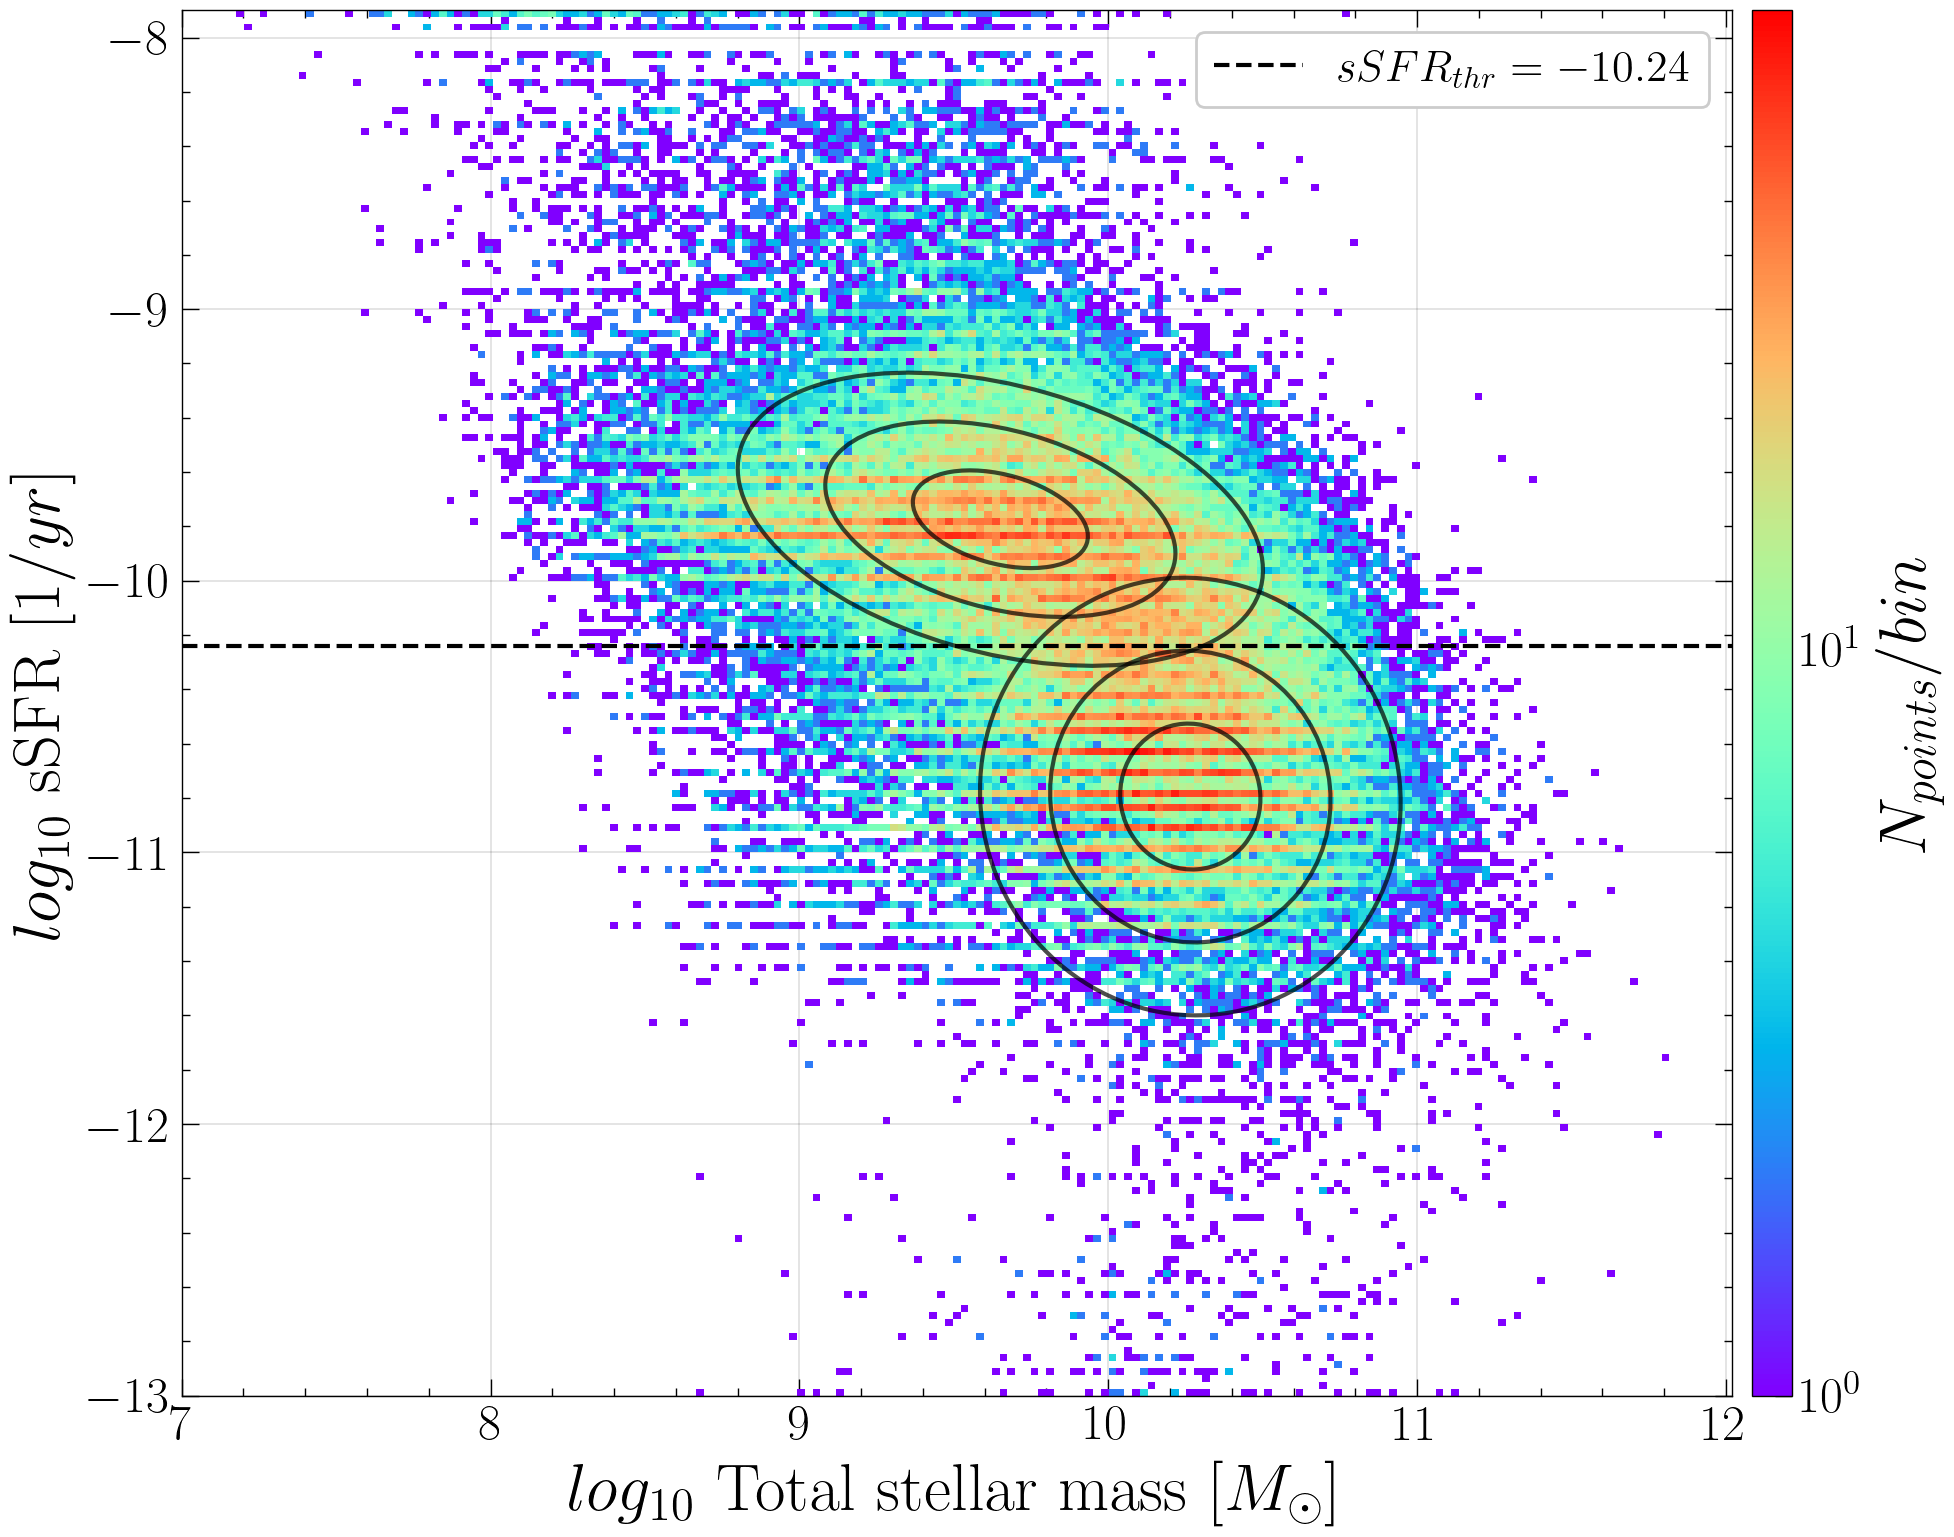

In [4]:
# Base code drawn from Ivezic, Figure 3.22, edited by G. Richards to simplify the example

from matplotlib.patches import Ellipse
from astroML.stats import fit_bivariate_normal

x_min = 7
x_max = np.max(x_data)
y_min = -13
y_max = np.max(y_data)
hist2d_nbins = 200

fig = plt.figure(figsize=(10, 9))
ax = fig.add_subplot(111)

binx = np.linspace(start=x_min, stop=x_max, num=hist2d_nbins)
biny = np.linspace(start=y_min, stop=y_max, num=hist2d_nbins)
hist = ax.hist2d(x_data, y_data, bins=(binx, biny), norm=matplotlib.colors.LogNorm(), cmap=plt.cm.rainbow)
cax = fig.add_axes([0.91, 0.11, 0.02, 0.77])
fig.colorbar(hist[3], cax=cax, label='$N_{points}/bin$')

y_separator = np.log10(5.734e-11)
ax.axhline(y_separator, lw=1.5, color='black', ls='--', label=f'$sSFR_{{thr}}={y_separator:.2f}$')

ax.set_xlim(x_min, x_max)
ax.set_ylim(y_min, y_max)
ax.set_xlabel('$log_{10}$ Total stellar mass $[M_\odot]$')
ax.set_ylabel('$log_{10}$ sSFR $[1/yr]$');


# Fit the main sequence with a bivariate normal distribution and plot it via robust estimators
mask = y_data >= y_separator
x_fit = np.array(x_data[mask])
y_fit = np.array(y_data[mask])
mean_r, sigma_x_r, sigma_y_r, alpha_r = fit_bivariate_normal(x_fit, y_fit, robust=True)

for N in (1, 2, 3):
    ax.add_patch(Ellipse(mean_r, N * sigma_x_r, N * sigma_y_r, 
                         angle=alpha_r * 180./np.pi, lw=1.5, 
                         ec='black', fc='none', alpha=0.7))
    
    
# Fit the passive region with a bivariate normal distribution and plot it via robust estimators
mask = y_data < y_separator
x_fit = np.array(x_data[mask])
y_fit = np.array(y_data[mask])
mean_r, sigma_x_r, sigma_y_r, alpha_r = fit_bivariate_normal(x_fit, y_fit, robust=True)

for N in (1, 2, 3):
    ax.add_patch(Ellipse(mean_r, N * sigma_x_r, N * sigma_y_r, 
                         angle=alpha_r * 180./np.pi, lw=1.5, 
                         ec='black', fc='none', alpha=0.7))
    
ax.legend(loc='upper right')

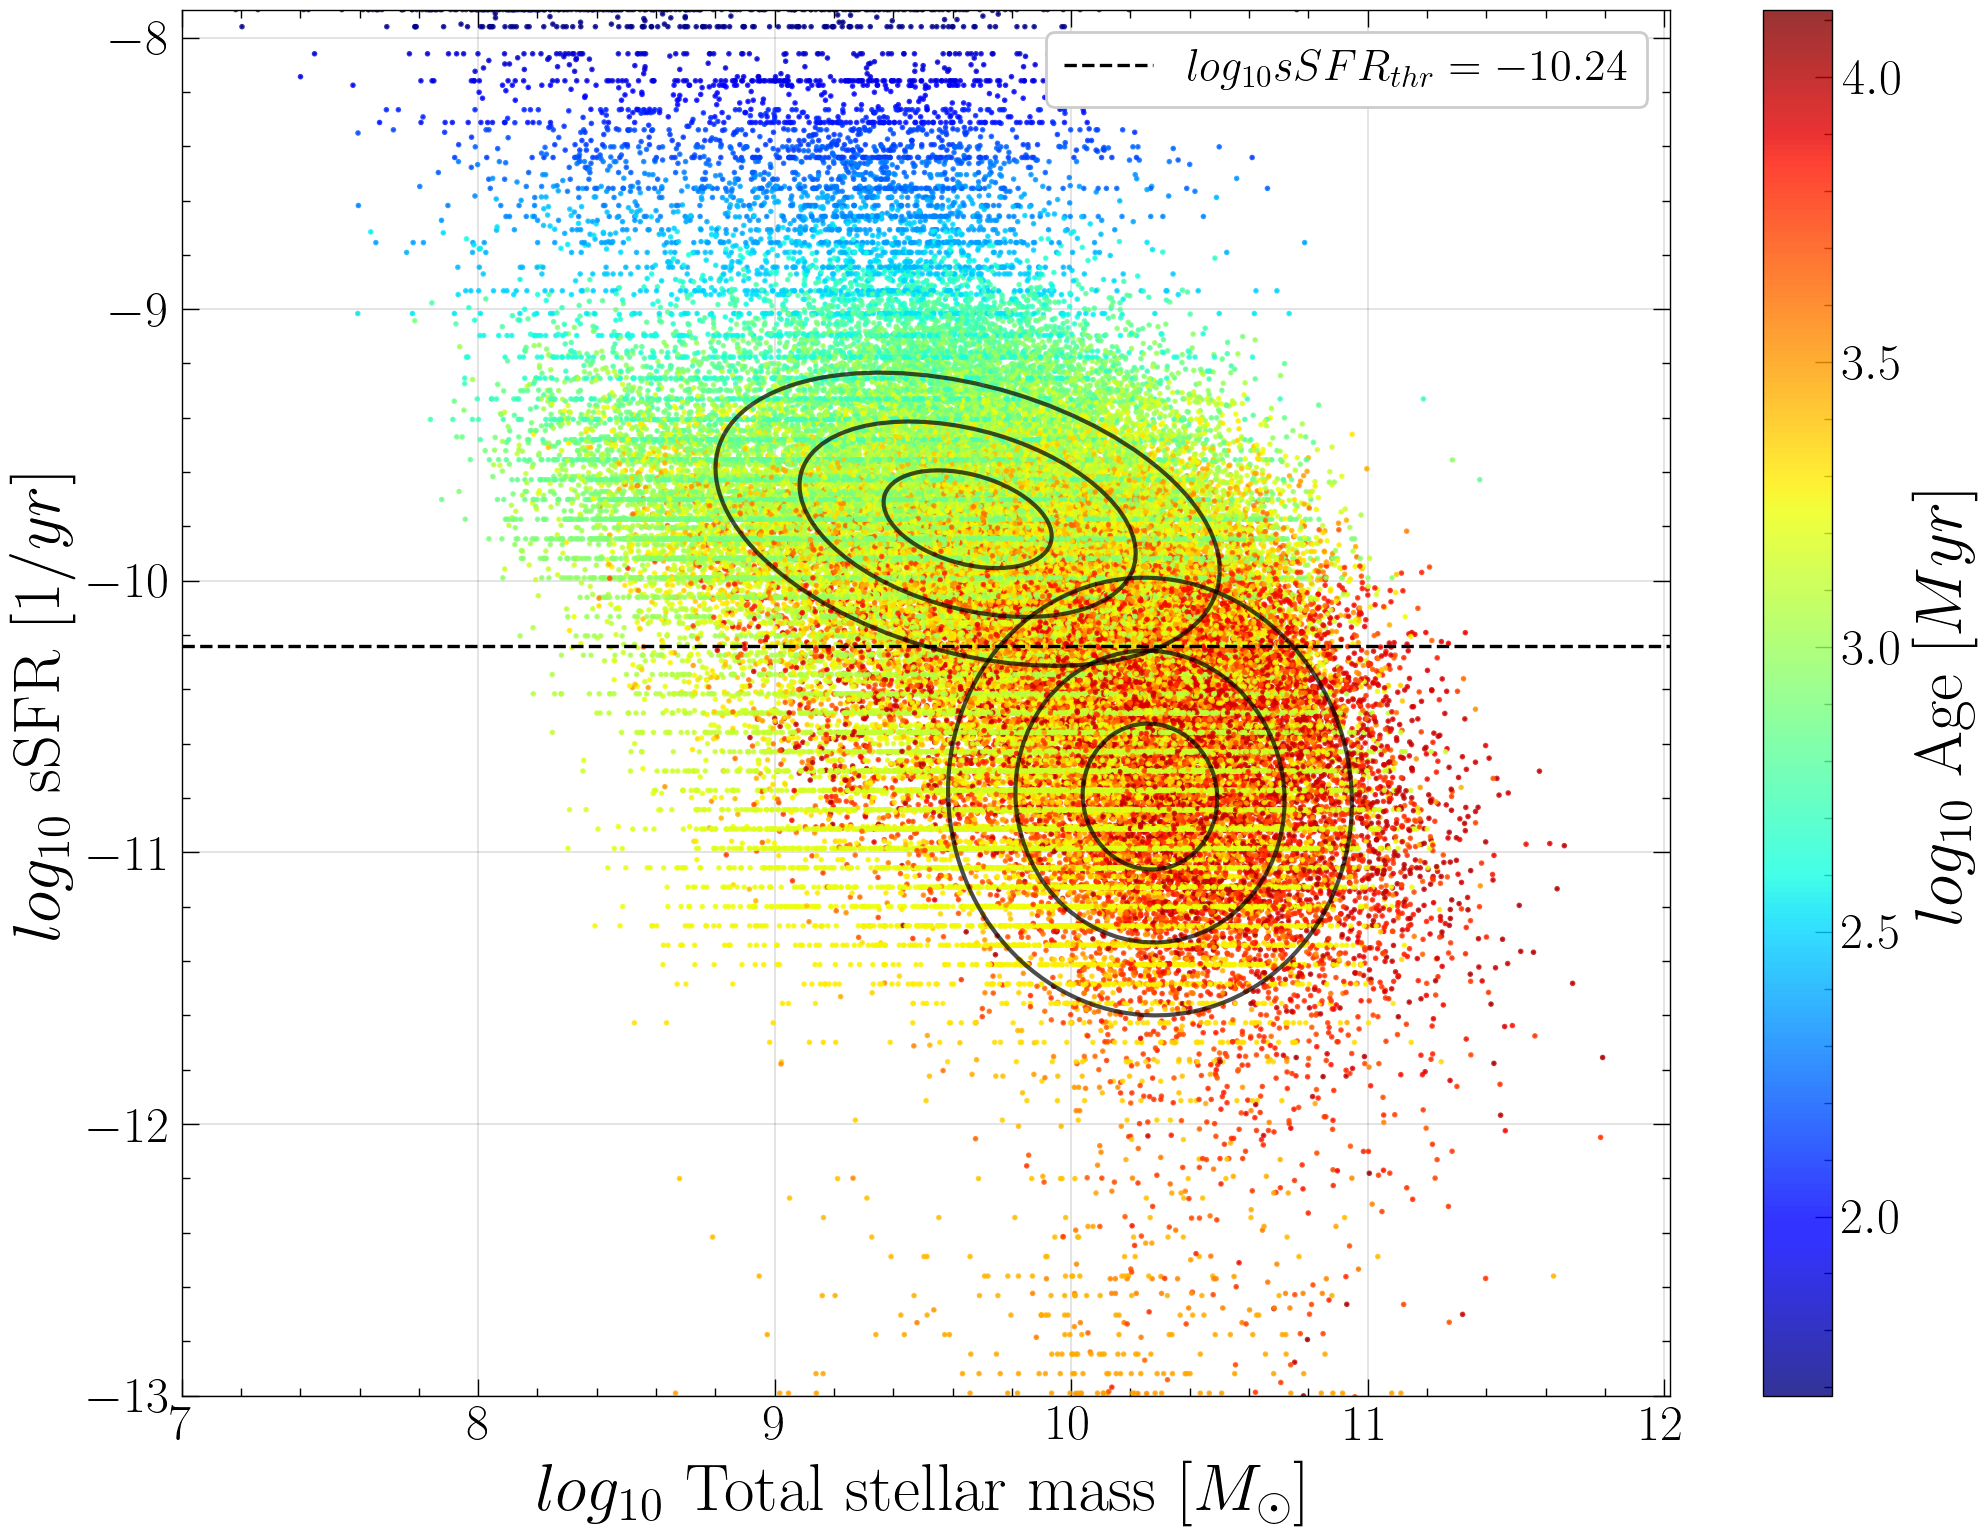

In [5]:
#x_data = np.log10(results['best.stellar.m_star'])
#y_data = np.log10(results['bayes.sfh.sfr10Myrs']/results['best.stellar.m_star'])
colormap_age = np.log10(results['best.stellar.age_m_star'])

#plt.rcParams['figure.figsize'] = [10 , 8]
plt.rcParams['figure.figsize'] = [12 , 9]
fig, ax = plt.subplots(1, 1)

x_min = 7
x_max = np.max(x_data)
y_min = -13
y_max = np.max(y_data)

plt.scatter(x_data, y_data, c=colormap_age, cmap=plt.cm.jet, alpha=0.8, s=1)
plt.colorbar(label='$log_{{10}}$ Age $[Myr]$')

plt.axhline(y_separator, lw=1.2, color='black', ls='--', label=f'$log_{{10}} sSFR_{{thr}}={y_separator:.2f}$')

plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)

plt.xlabel('$log_{10}$ Total stellar mass $[M_\odot]$')
plt.ylabel('$log_{10}$ sSFR $[1/yr]$');
plt.legend(loc='upper right')



# Fit the main sequence with a bivariate normal distribution and plot it via robust estimators
mask = y_data >= y_separator
x_fit = np.array(x_data[mask])
y_fit = np.array(y_data[mask])
mean_r, sigma_x_r, sigma_y_r, alpha_r = fit_bivariate_normal(x_fit, y_fit, robust=True)

for N in (1, 2, 3):
    ax.add_patch(Ellipse(mean_r, N * sigma_x_r, N * sigma_y_r, 
                         angle=alpha_r * 180./np.pi, lw=1.5, 
                         ec='black', fc='none', alpha=0.7))
    
    
# Fit the passive region with a bivariate normal distribution and plot it via robust estimators
mask = y_data < y_separator
x_fit = np.array(x_data[mask])
y_fit = np.array(y_data[mask])
mean_r, sigma_x_r, sigma_y_r, alpha_r = fit_bivariate_normal(x_fit, y_fit, robust=True)

for N in (1, 2, 3):
    ax.add_patch(Ellipse(mean_r, N * sigma_x_r, N * sigma_y_r, 
                         angle=alpha_r * 180./np.pi, lw=1.5, 
                         ec='black', fc='none', alpha=0.7))

# Clustering 

In [12]:
x_data = results['best.stellar.m_star']
y_data = results['best.sfh.sfr10Myrs']/results['best.stellar.m_star']

mask_nonNan = y_data>1e-15
x_data = x_data[mask_nonNan]
y_data = y_data[mask_nonNan]

x_data = np.log10(x_data)
y_data = np.log10(y_data)

In [13]:
def PlotClusters(labels):
    labels_unique = np.unique(labels)
    n_clusters = len(labels_unique[labels_unique >= 0])
    print(f'labels = {labels_unique}')
    print("number of estimated clusters :", n_clusters)
    
    fig = plt.figure(figsize=(12,8))
    plt.scatter(X[labels==-1,0], X[labels==-1,1], color='gray', alpha=0.5)
    for i in range(n_clusters):
        plt.scatter(X[labels==i,0], X[labels==i,1], alpha=0.5)
    plt.xlabel('Total stellar mass $[M_\odot]$')
    plt.ylabel('sSFR $[1/yr]$')
    
    return fig

## 1) KMeans

[KMeans Documentation](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html)

In [7]:
from sklearn.cluster import KMeans

X = np.array([x_data, y_data]).T

n_clusters = 2
#centers = np.array([[9.3, 0.2], [10.1, 0.01]]) 
clf = KMeans(n_clusters=n_clusters, init='k-means++', n_init='auto', verbose=True)
clf.fit(X)
labels = clf.predict(X)  

Initialization complete


AttributeError: 'NoneType' object has no attribute 'split'

In [ ]:
fig = PlotClusters(labels)

NameError: name 'labels' is not defined

## 2) MeanShift

[MeanShift Documentation](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.MeanShift.html)

[estimate_bandwidth Documentation](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.estimate_bandwidth.html)

In [14]:
from sklearn.cluster import MeanShift
from sklearn import preprocessing

scaler = preprocessing.StandardScaler()
bandwidth = 0.7 # Determined by using sklearn.cluster.estimate_bandwidth()

#from sklearn.cluster import estimate_bandwidth
#bandwidth = estimate_bandwidth(X, n_jobs=int(mp.cpu_count()/2)) # This takes a long time...beware

In [15]:
ms = MeanShift(bandwidth=bandwidth, bin_seeding=True, cluster_all=True, n_jobs=int(mp.cpu_count()/2))
ms.fit(scaler.fit_transform(X))

labels = ms.labels_

labels = [0 1 2 3 4 5 6 7 8 9]
number of estimated clusters : 10


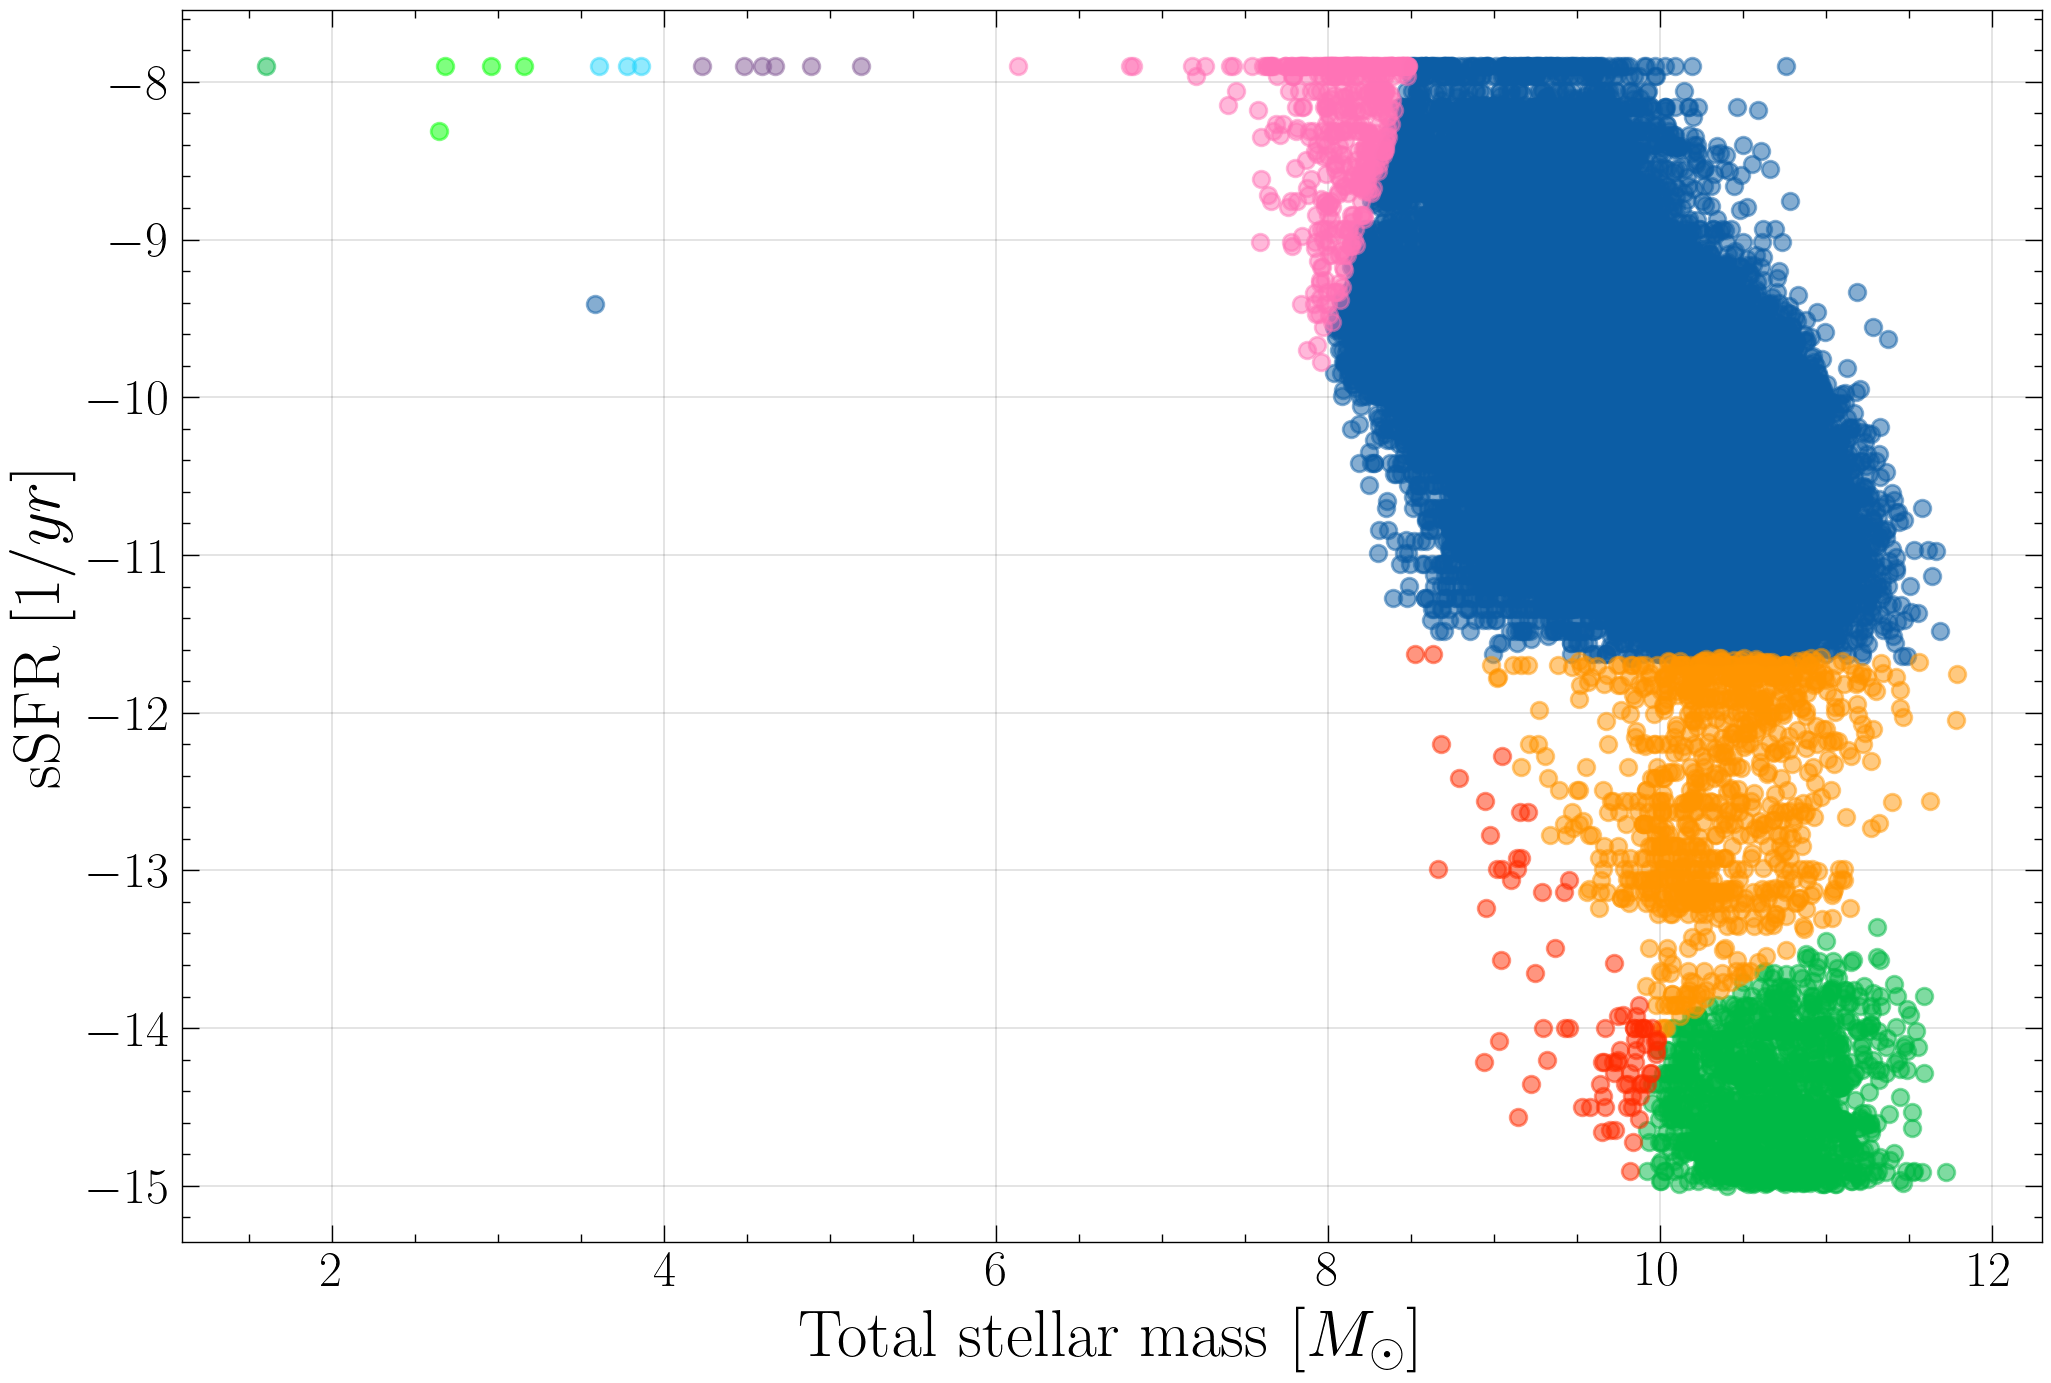

In [16]:
fig = PlotClusters(labels)

## 3) DBSCAN

[DBSCAN Documentation](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html)

The computation takes a while

In [17]:
from sklearn.cluster import DBSCAN

dbscan = False

if dbscan:
    # Initialize DBSCAN object
    dbscan = DBSCAN(eps=0.5, min_samples=500, n_jobs=1)

    # Fit model on data
    labels = dbscan.fit_predict(X)

labels = [0 1 2 3 4 5 6 7 8 9]
number of estimated clusters : 10


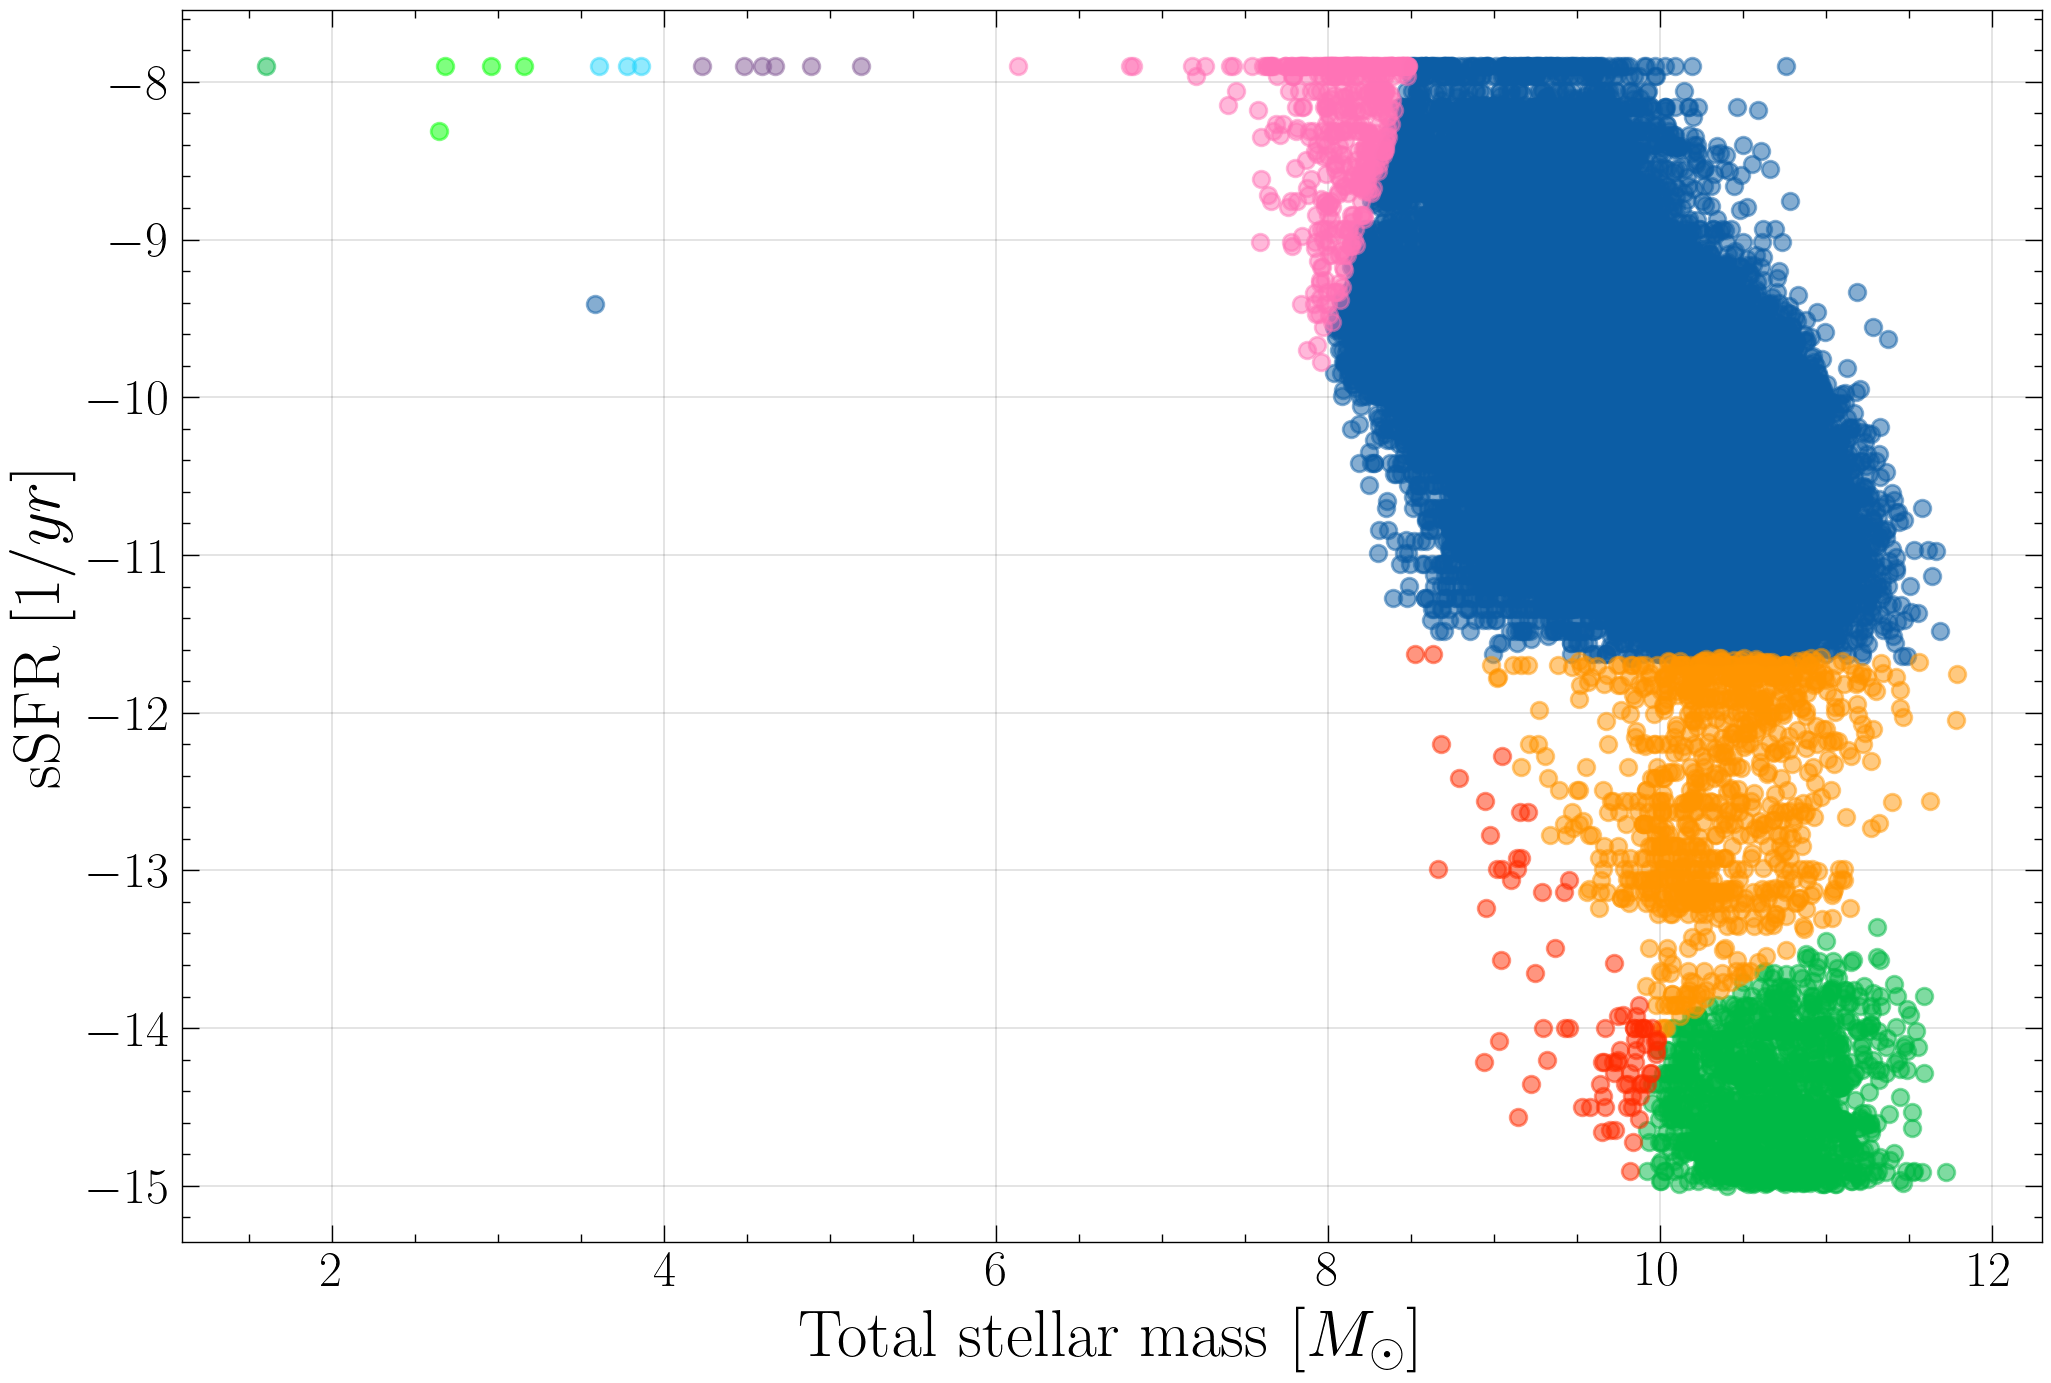

In [18]:
fig = PlotClusters(labels)

# 3D Histogram

In [19]:
run_3dHist = False

if run_3dHist:
    
    # Initialize the data (in log-scale) and the boundaries
    x_data = np.log10(results['best.stellar.m_star'])
    y_data = np.log10(results['best.sfh.sfr10Myrs']/results['best.stellar.m_star'])

    x_min = 6
    x_max = np.max(x_data)
    y_min = -13
    y_max = np.max(y_data)
    hist2d_nbins = 200

    # Make the 3d plot interactive
    %matplotlib widget

    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')

    # Initialize the histogram
    binx = np.linspace(start=x_min, stop=x_max, num=hist2d_nbins)
    biny = np.linspace(start=y_min, stop=y_max, num=hist2d_nbins)
    hist, xedges, yedges = np.histogram2d(x_data, y_data, bins=(binx, biny))

    # Positions of the bars
    xpos, ypos = np.meshgrid((xedges[:-1]+xedges[1:])/2, (yedges[:-1]+yedges[1:])/2)
    xpos = xpos.flatten()
    ypos = ypos.flatten()
    zpos = np.zeros_like (xpos)

    # Sizes of the bars
    dx = xedges[1] - xedges[0]
    dy = yedges[1] - yedges[0]
    dz = hist.flatten()

    # Colormap: scale each z to [0,1] and get their rgb values
    cmap = matplotlib.colormaps.get_cmap('jet') 
    rgba = [cmap((k-np.min(dz))/np.max(dz)) for k in dz] 

    # Set the height of the bars in log-scale
    for i in range(len(dz)):
        if dz[i]>0: dz[i] = np.log10(dz[i])

    # Plot the 3D histogram
    ax.bar3d(xpos, ypos, zpos, dx, dy, dz, color=rgba, zsort='average')
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.set_xlabel('$log_{10}$ Total stellar mass $[M_\odot]$')
    ax.set_ylabel('$log_{10}$ sSFR $[1/yr]$');